In [1]:
import os
import utils
import connectome_create
# viz_method = one of ['itkwidgets', 'vtk']
viz_method = 'vtk'

# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import nglui.statebuilder as ngstbld

# this is the EM specific package for querying the EM data
from caveclient import CAVEclient


from meshparty import trimesh_io, trimesh_vtk
from meshparty import skeletonize, skeleton_io, skeleton
import cloudvolume

%load_ext autoreload
%autoreload 2

query timestamp: 2024-01-17 08:10:01.179472-08:00 (1705507801.179472)


In [2]:
# client = CAVEclient()

# # if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
# client.auth.get_new_token(open=True)
# # # if you have not yet setup this computer, uncomment this below line
# # # paste the token from the website in, and run the line


In [3]:
# client.auth.save_token(token="fca0294ed408d104e0eebe74514c744b", overwrite=True)

# # # then comment or delete the line as you don't need to run it on this computer  again

In [4]:
datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

In [5]:
client.materialize.get_versions()


[972, 984, 989, 992, 604, 986, 840]

In [6]:
client.materialize.get_table_metadata('left_t1_mn_order_module_table_v1')
mn_mod = client.materialize.query_table('left_t1_mn_order_module_table_v1')
mn_mod

,id,created,superceded_id,valid,tag,tag2,pt_supervoxel_id,pt_root_id,pt_position
0,70,2023-12-22 18:45:41.337612+00:00,NaN,t,0,coxa_promotion,72975275004512296,648518346487756866,"[26759, 87253, 2174]"
1,71,2023-12-22 18:45:41.371003+00:00,NaN,t,1,coxa_promotion,73116080876550816,648518346491659326,"[31494, 89253, 1423]"
2,72,2023-12-22 18:45:41.383633+00:00,NaN,t,2,coxa_promotion,72975343790906622,648518346517437482,"[28385, 88521, 2251]"
3,73,2023-12-22 18:45:41.395834+00:00,NaN,t,3,coxa_promotion,72904974778207768,648518346500725685,"[26568, 89275, 1711]"
4,74,2023-12-22 18:45:41.409246+00:00,NaN,t,4,coxa_rotator_adductor,72623499935890376,648518346479325585,"[17144, 89099, 2005]"
...,...,...,...,...,...,...,...,...,...
64,134,2023-12-22 18:45:42.141816+00:00,NaN,t,64,tarsus_depressor_ventralU,73045712736535157,648518346486890393,"[29188, 88984, 2669]"
65,135,2023-12-22 18:45:42.153206+00:00,NaN,t,65,tibia_ta_flex_A,72764169040166640,648518346472699657,"[20633, 87133, 2615]"
66,136,2023-12-22 18:45:42.165720+00:00,NaN,t,66,tibia_ta_flex_B,72764168973359401,648518346489767549,"[21620, 87497, 2568]"
67,137,2023-12-22 18:45:42.177964+00:00,NaN,t,67,tibia_ta_flex_B,72553200313457288,648518346495467855,"[16326, 90435, 2698]"


In [7]:
t1_mns_df = client.materialize.query_table('motor_neuron_table_v7',timestamp=connectome_create.get_timestamp())
t1_mns_df['pt_position'] = t1_mns_df['pt_position'].apply(lambda x: tuple(x))

ordered_t1_table = client.materialize.query_table('left_t1_mn_order_module_table_v1',timestamp='now')
ordered_t1_table['pt_position'] = ordered_t1_table['pt_position'].apply(lambda x: tuple(x))
ordered_t1_table['tag'] = ordered_t1_table['tag'].apply(lambda x: int(x))

t1_mns_df = t1_mns_df.merge(ordered_t1_table,how='right',left_on='pt_position',right_on='pt_position')
t1_mns_df = t1_mns_df[['classification_system','cell_type','pt_position','tag','tag2','pt_root_id_x']]
t1_mns_df = t1_mns_df.rename(columns={'pt_root_id_x':'pt_root_id'})

In [8]:
t1_mns_df

,classification_system,cell_type,pt_position,tag,tag2,pt_root_id
0,D1_T1L,tergopleural_promotor_pleural_promotor_in_thor...,"(26759, 87253, 2174)",0,coxa_promotion,648518346487756866
1,D2_T1L,tergopleural_promotor_pleural_promotor_in_thor...,"(31494, 89253, 1423)",1,coxa_promotion,648518346491659326
2,D1_T1L,tergopleural_promotor_pleural_promotor_in_thor...,"(28385, 88521, 2251)",2,coxa_promotion,648518346517437482
3,D2_T1L,tergopleural_promotor_pleural_promotor_in_thor...,"(26568, 89275, 1711)",3,coxa_promotion,648518346479446972
4,V4_T1L,sternal_anterior_rotator_in_thorax_miller_31,"(17144, 89099, 2005)",4,coxa_rotator_adductor,648518346479325585
...,...,...,...,...,...,...
64,L1_T1L,tarsus_depressor_in_tibia_ventralU,"(29188, 88984, 2669)",64,tarsus_depressor_ventralU,648518346486890393
65,L1_T1L,tarsus_unidentified_in_tibia_Bslow,"(20633, 87133, 2615)",65,tibia_ta_flex_A,648518346480904925
66,L1_T1L,tarsus_unidentified_in_tibia_A1,"(21620, 87497, 2568)",66,tibia_ta_flex_B,648518346489767549
67,L1_T1L,tarsus_unidentified_in_tibia_A2,"(16326, 90435, 2698)",67,tibia_ta_flex_B,648518346495467855


In [9]:
All = slice(None)

# Create the pre_to_mn_df 
with index (segID,has_soma,sensory,neck,local) 
x 
(side, nerve,segment,function,muscle,rank,segID)

In [10]:
# Iterates down the multiindex of motor neurons, selecting similar motor neuron segID to query for presynaptic partners.
# Inputs: client, mn_index and optional side
# returns: 

t1_mns_df = client.materialize.query_table('motor_neuron_table_v7',timestamp=connectome_create.get_timestamp())
t1_mns_df.index = connectome_create.mn_multi_index(t1_mns_df)
All = slice(None)
mn_index = t1_mns_df.loc[('L',All,All,All,All,All,All),:]
full_left_df = client.materialize.synapse_query(post_ids = t1_mns_df.loc['L',:].pt_root_id.to_list(),timestamp=connectome_create.get_timestamp())
print(full_left_df.shape)

(271145, 11)


In [11]:
df = full_left_df.loc[:,['pre_pt_root_id','post_pt_root_id']]

# Then use factorize, which encodes each occurance in a list, in this case of paired root_ids, pre and post
ij,tups = pd.factorize(list(zip(*map(df.get,df))))

# Then create a dictionary out of each occurance, storing the number of factorized codes
result = dict(zip(tups, np.bincount(ij)))

# Finally, turn the result into series, with the tuples of pt_root_ids as the multiindex
tupseries = pd.Series(result)

thresh = 3
# Finally, threshold by the connection strength and perfom the unstack operation
thresholdedtupseries = tupseries[tupseries>=thresh]
prelim_pre_df = thresholdedtupseries.unstack(fill_value=0)

# takes ~ 15 seconds,
print(prelim_pre_df.shape)
pre_to_mn_df = prelim_pre_df.loc[:,mn_index.index.get_level_values('segID').to_list()]
pre_to_mn_df.columns = mn_index.index

(3984, 69)


In [12]:
soma_table = client.materialize.query_table('neuron_somas_dec2022',timestamp=connectome_create.get_timestamp())
neckns_df = client.materialize.query_table('neck_connective',timestamp=connectome_create.get_timestamp())
all_sensory = connectome_create.get_unduplicated_sensory_axon_table(client)

pmn_index = pre_to_mn_df.index.to_frame()
pmn_index.rename(columns={0:'segID'},inplace=True)
pmn_index['motor'] = pmn_index.segID.isin(mn_index.pt_root_id)
pmn_index['has_soma'] = pmn_index.segID.isin(soma_table.pt_root_id)
pmn_index['sensory'] = pmn_index.segID.isin(all_sensory.pt_root_id)
pmn_index['neck'] = pmn_index.segID.isin(neckns_df.pt_root_id)
pmn_index['local'] = False
pmn_index.neck.sum(axis=0)
pre_to_mn_df.index = pd.MultiIndex.from_frame(pmn_index)

# Sort the matrix

In [13]:
import utils
s = pre_to_mn_df.sum(axis=0)
pre_to_mn_df = pre_to_mn_df[s.sort_values(ascending=True).index]

new_idx = utils.sort_segment_fcn_index(pre_to_mn_df.columns)
pre_to_mn_df = pre_to_mn_df[new_idx]

# Create cell_class

In [14]:
### Motor neurons
# segID	motor	has_soma	sensory	 neck	local	
m_r_tup = (All,True,All,All,All,All)
mns = pre_to_mn_df.loc[m_r_tup,:]
mns = mns.loc[mns.sum(axis=1).sort_values(ascending=False).index,:]
print('mns shape: {}'.format(mns.shape))

### sensory neurons
# segID	motor	has_soma	sensory	 neck	local	
s_r_tup = (All,False,False,True,False,False)
sensory = pre_to_mn_df.loc[s_r_tup,:]
sensory = sensory.loc[sensory.sum(axis=1).sort_values(ascending=False).index,:]
print('sensory shape: {}'.format(sensory.shape))

### descending neurons
# segID	motor	has_soma	sensory	 neck	local	
descending = pre_to_mn_df.loc[(All,False,False,False,True,All),:]
descending = descending.loc[descending.sum(axis=1).sort_values(ascending=False).index,:]
print('descending shape: {}'.format(descending.shape))

### How many ascending neurons # 138
# segID	motor	has_soma	sensory	 neck	local	
ascending = pre_to_mn_df.loc[(All,False,True,False,True,False),:]
ascending = ascending.loc[ascending.sum(axis=1).sort_values(ascending=False).index,:]
print('ascending shape: {}'.format(ascending.shape))

### VNC neurons
# segID	motor	has_soma	sensory	 neck	local	
vncns = pre_to_mn_df.loc[(All,False,True,False,False,False),:]
vncns = vncns.loc[vncns.sum(axis=1).sort_values(ascending=False).index,:]
print('vncns shape: {}'.format(vncns.shape))

## strange motor neurons
sensmns = pre_to_mn_df.loc[(All,False,True,True,False,False),:]
sensmns = sensmns.loc[sensmns.sum(axis=1).sort_values(ascending=False).index,:]
print('sensmns shape: {}'.format(sensmns.shape))

(mns.shape[0]+sensory.shape[0]+descending.shape[0] + ascending.shape[0] + vncns.shape[0] + sensmns.shape[0] )

mns shape: (37, 69)
sensory shape: (192, 69)
descending shape: (232, 69)
ascending shape: (175, 69)
vncns shape: (964, 69)
sensmns shape: (1, 69)


1601

# Look at fragments briefly

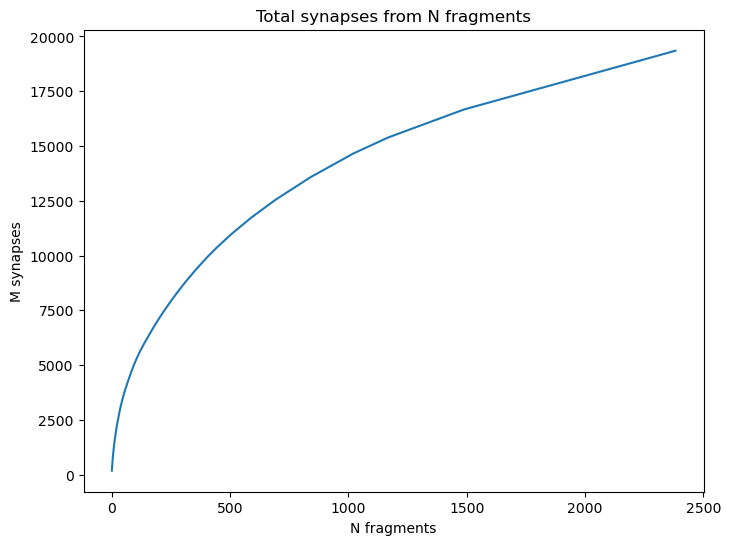

In [15]:
# Neurons with a soma and not ascending
fragments = pre_to_mn_df.loc[(All,False,False,False,False,False),:].copy()
### VNC neurons
# segID	motor	has_soma	sensory	 neck	local	
fragments = pre_to_mn_df.loc[(All,False,False,False,False,False),:]
fragments = fragments.loc[fragments.sum(axis=1).sort_values(ascending=False).index,:]

total = fragments.sum(axis=1)
tot = total.cumsum()#/total.sum() # The fraction of total input from a given fragment
n = np.array([i for i in range(len(tot))])  # assign a number to neurons
frc = n/n.sum()

fig = plt.figure(1, figsize=(8, 6))
ax1 = plt.subplot2grid((1,1),(0,0))

# ax1.scatter(x, y)
ax1.plot(n,tot)#, marker='o')
plt.sca(ax1)
plt.title('Total synapses from N fragments')
plt.ylabel('M synapses')
plt.xlabel('N fragments')
plt.show()
# locs, labels = plt.xticks(ticks=x, labels=lbls, rotation=90)

In [16]:
connectome_create.save_pre_to_mn_df(pre_to_mn_df,ext='edited')

c:\Users\tony\Code\connectomics\connectomics\dfs_pre_to_mn\pre_to_mn_df_edited_20240627.pkl
(3984, 69)


In [17]:
ordered_pMN_to_MN_df = pd.concat([
    mns,
    descending,
    sensory,
    vncns,
    ascending,
    sensmns,
    fragments
])
print(ordered_pMN_to_MN_df.shape)

(3984, 69)


In [18]:
connectome_create.save_pre_to_mn_df(ordered_pMN_to_MN_df,ext='ordered')

c:\Users\tony\Code\connectomics\connectomics\dfs_pre_to_mn\pre_to_mn_df_ordered_20240627.pkl
(3984, 69)


# Load Premotor connectivity matrix

In [19]:
pre_to_mn_df = ordered_pMN_to_MN_df # connectome_create.load_pre_to_mn_df(ext='ordered')


In [20]:
pre_to_mn_df

side                                                                                                    L  \
nerve                                                                                              Dorsal   
segment                                                                                            thorax   
function                                                                                            swing   
muscle                                                tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                                                    0   
segID                                                                                  648518346487756866   
segID              motor has_soma sensory neck  local                                                       
648518346470645246 True  True     True    False False                                                  0    
648518346478129901 True  True     False   False False                                                  3    
648518346490822141 True  True     True    False False                                                  0    
648518346466168368 True  True     False   False False                                                  0    
648518346514306270 True  True     False   False False                                                  0    
...                                                                                                   ...   
648518346435431294 False False    False   False False                                                  0    
648518346505019267 False False    False   False False                                                  0    
648518346492606229 False False    False   False False                                                  0    
648518346479491264 False False    False   False False                                                  0    
648518346491364917 False False    False   False False                                                  3    

side                                                                      \
nerve                                                                      
segment                                                                    
function                                                                   
muscle                                                                     
rank                                                                       
segID                                                 648518346491659326   
segID              motor has_soma sensory neck  local                      
648518346470645246 True  True     True    False False                  3   
648518346478129901 True  True     False   False False                  0   
648518346490822141 True  True     True    False False                  0   
648518346466168368 True  True     False   False False                  0   
648518346514306270 True  True     False   False False                  0   
...                                                                  ...   
648518346435431294 False False    False   False False                  0   
648518346505019267 False False    False   False False                  0   
648518346492606229 False False    False   False False                  0   
648518346479491264 False False    False   False False                  0   
648518346491364917 False False    False   False False                  0   

side                                                                      \
nerve                                                                      
segment                                                                    
function                                                                   
muscle                                                                     
rank                                                                       
segID                      

# Test suite

In [21]:
All = slice(None)

# # How many motor neurons are presynaptic to motor neurons
# # segID	motor	has_soma	sensory	 neck	local	
motor = pre_to_mn_df.loc[(All,True,True,All,False,False),:]
# descending.index.get_level_values('segID').to_list()
print(motor.shape)

# How many sensory neurons # 94
# segID	motor	has_soma	sensory	 neck	local	
sensory = pre_to_mn_df.loc[(All,False,False,True,False,False),:]
# descending.index.get_level_values('segID').to_list()
print(sensory.shape)

# How many descending neurons # 217 214?
# segID	motor	has_soma	sensory	 neck	local	
descending = pre_to_mn_df.loc[(All,False,False,False,True),:]
# descending.index.get_level_values('segID').to_list()
print(descending.shape)

# How many motor neurons are presynaptic to motor neurons
# segID	motor	has_soma	sensory	 neck	local	
ascending = pre_to_mn_df.loc[(All,False,True,False,True,False),:]
# descending.index.get_level_values('segID').to_list()
print(ascending.shape)
# some ascending that should be ascending
# 648518346507084872
# 648518346480786912
# 648518346490374748
sid = 648518346504729203
ascending.index.get_level_values('segID')==sid
# All are here

# Fragments?
# segID	motor	has_soma	sensory	 neck	local	
sensmns = pre_to_mn_df.loc[(All,False,True,True,False,False),:]
print(sensmns.shape)

# Fragments?
# segID	motor	has_soma	sensory	 neck	local	
fragments = pre_to_mn_df.loc[(All,False,False,False,False,False),:]
print(fragments.shape)

# Local and intersegmental? # 880
# segID	motor	has_soma	sensory	 neck	local	
vncns = pre_to_mn_df.loc[(All,False,True,False,False,False),:]
# descending.index.get_level_values('segID').to_list()
print(vncns.shape)


(37, 69)
(192, 69)
(232, 69)
(175, 69)
(1, 69)
(2383, 69)
(964, 69)


# Find intersegmental neurons
Go through the vnc premotor neurons and look for a synapse outside the left hand box.
Once you find one, move to the next premotor neuron

In [22]:
# Soma box
soma_table = client.materialize.query_table('somas_dec2022',timestamp=connectome_create.get_timestamp())
soma_table.index = soma_table.pt_root_id

In [23]:
sx = [-3000, 3000]
sy = [-3000, 3000]
sz = [-300, 300]

# T1 bounding box, click on neuroglancer instance
All = slice(None)
x = [3000 , 38000]
y = [90483, 123190] # extended the boundaries a bit 5/10/22
z = [980, 3858]

t1 = lambda b: (b[0]>=x[0]) & (b[0]<=x[1]) & (b[1]>=y[0]) & (b[1]<=y[1]) & (b[2]>=z[0]) & (b[2]<=z[1])

def get_non_T1_inputs(iln_syn_df, s):
    in_T1_box = iln_syn_df.loc[:,['post_pt_position']].applymap(t1)
    pts_out_of_T1 = iln_syn_df.loc[~in_T1_box.post_pt_position,:]
    pts_in_T1 = iln_syn_df.loc[in_T1_box.post_pt_position,:]
    nearsoma = lambda b: (b[0]>=s[0]+sx[0]) & (b[0]<=s[0]+sx[1]) & (b[1]>=s[1]+sy[0]) & (b[1]<=s[1]+sy[1]) & (b[2]>=s[2]+sz[0]) & (b[2]<=s[2]+sz[1])
    in_soma_box = pts_out_of_T1.loc[:,['post_pt_position']].applymap(nearsoma)
    pts_out_of_T1 = pts_out_of_T1.loc[~in_soma_box.post_pt_position,:]
    return pts_out_of_T1

In [24]:
from datetime import date
vncnsindex = vncns.index.to_frame()
vncnsindex.index = vncnsindex.index.get_level_values('segID')
vncnsindex['non_T1_count'] = 0

row_i = 0
row_f = 99
cnt = 0
while row_i<vncnsindex.shape[0]:
    print('Querying [{}:{}]'.format(row_i,row_f))
    rows_df = vncnsindex.iloc[row_i:row_f,:]
    iln_syn_df = client.materialize.synapse_query(post_ids = rows_df.index.get_level_values('segID').to_list(),timestamp=connectome_create.get_timestamp())
    for idx in rows_df.index.get_level_values('segID').to_list():
        try:
            s=soma_table.loc[idx,:].pt_position
        except KeyError:
            if 'fraglist' not in locals():
                today = date.today()
                d1 = today.strftime("%Y%m%d")
                fn = './dfs_saved/' + 'frag_df' + '_' + d1 + '.pkl'
                fraglist= pd.read_pickle(fn)
            if sid in fraglist.pt_root_id.to_list():
                print('{} is a known fragment of a local neuron'.format(sid))
                vncnsindex.loc[idx,'local'] = True
        
        non_T1_inputs = get_non_T1_inputs(iln_syn_df.loc[iln_syn_df['post_pt_root_id']==idx], s)
        if non_T1_inputs.empty:
            #print('{} is local'.format(sid))
            vncnsindex.loc[idx,'local'] = True
        else: 
            #print('{} has {} inputs outside of T1'.format(sid,non_T1_inputs.shape[0]))
            vncnsindex.loc[idx,'non_T1_count'] = non_T1_inputs.shape[0]
        
    print('Done [{}:{}]'.format(row_i,row_f))
    row_i = row_f+1
    row_f = min([row_i+99,vncnsindex.shape[0]])
    
vncns.index = pd.MultiIndex.from_frame(vncnsindex)


Querying [0:99]
Done [0:99]
Querying [100:199]
Done [100:199]
Querying [200:299]
Done [200:299]
Querying [300:399]
Done [300:399]
Querying [400:499]
Done [400:499]
Querying [500:599]
Done [500:599]
Querying [600:699]
Done [600:699]
Querying [700:799]
Done [700:799]
Querying [800:899]
Done [800:899]
Querying [900:964]
Done [900:964]


# Reconcatenate dataframes

In [25]:
mnindex= motor.index.to_frame()
mnindex.index = mnindex.index.get_level_values('segID')
mnindex['non_T1_count'] = 0
motor.index = pd.MultiIndex.from_frame(mnindex)

descindex= descending.index.to_frame()
descindex.index = descindex.index.get_level_values('segID')
descindex['non_T1_count'] = 0
descending.index = pd.MultiIndex.from_frame(descindex)

sensoryindex= sensory.index.to_frame()
sensoryindex.index = sensoryindex.index.get_level_values('segID')
sensoryindex['non_T1_count'] = 0
sensory.index = pd.MultiIndex.from_frame(sensoryindex)

ascindex= ascending.index.to_frame()
ascindex.index = ascindex.index.get_level_values('segID')
ascindex['non_T1_count'] = 0
ascending.index = pd.MultiIndex.from_frame(ascindex)

sensmnsindex= sensmns.index.to_frame()
sensmnsindex.index = sensmnsindex.index.get_level_values('segID')
sensmnsindex['non_T1_count'] = 0
sensmns.index = pd.MultiIndex.from_frame(sensmnsindex)

frgindex= fragments.index.to_frame()
frgindex.index = frgindex.index.get_level_values('segID')
frgindex['non_T1_count'] = 0
fragments.index = pd.MultiIndex.from_frame(frgindex)

ordered_pMN_to_MN_df = pd.concat([
    motor,
    descending,
    sensory,
    vncns,
    ascending,
    sensmns,
    fragments,
])

In [26]:
connectome_create.save_pre_to_mn_df(ordered_pMN_to_MN_df,ext='vncns_inter_vs_local')

c:\Users\tony\Code\connectomics\connectomics\dfs_pre_to_mn\pre_to_mn_df_vncns_inter_vs_local_20240627.pkl
(3984, 69)


# Reorder

In [27]:
# segID	motor	has_soma	sensory	 neck	local	
pre_to_mn_df = ordered_pMN_to_MN_df

m_r_tup = (All,True,All,All,All,All)
motor = pre_to_mn_df.loc[m_r_tup,:]
motor = motor.loc[motor.sum(axis=1).sort_values(ascending=False).index,:]
print(motor.shape)

### sensory neurons
# segID	motor	has_soma	sensory	 neck	local	
s_r_tup = (All,False,False,True,False,False)
sensory = pre_to_mn_df.loc[s_r_tup,:]
sensory = sensory.loc[sensory.sum(axis=1).sort_values(ascending=False).index,:]
print(sensory.shape)

### weird mn neurons
# segID	motor	has_soma	sensory	 neck	local	
w_r_tup = (All,False,True,True,False,False)
sensmns = pre_to_mn_df.loc[w_r_tup,:]
sensmns = sensmns.loc[sensmns.sum(axis=1).sort_values(ascending=False).index,:]
print(sensmns.shape)

### descending neurons
# segID	motor	has_soma	sensory	 neck	local	
descending = pre_to_mn_df.loc[(All,False,False,False,True,All),:]
descending = descending.loc[descending.sum(axis=1).sort_values(ascending=False).index,:]
print(descending.shape)

### How many ascending neurons # 138
# segID	motor	has_soma	sensory	 neck	local	
ascending = pre_to_mn_df.loc[(All,False,True,False,True,False),:]
ascending = ascending.loc[ascending.sum(axis=1).sort_values(ascending=False).index,:]
print(ascending.shape)

### VNC neurons
# segID	motor	has_soma	sensory	 neck	local	
vncns = pre_to_mn_df.loc[(All,False,True,False,False,All,All),:]
vncns = vncns.loc[vncns.sum(axis=1).sort_values(ascending=False).index,:]
print(vncns.shape)

fragments = pre_to_mn_df.loc[(All,False,False,False,False,False),:]
fragments.shape

(37, 69)
(192, 69)
(1, 69)
(232, 69)
(175, 69)
(964, 69)


(2383, 69)

# Reclassify
Should some of these be local neurons instead?

In [28]:

local = vncns.loc[(All,False,True,False,False,True,All),:]
print('local shape:{}'.format(local.shape))

# peel off some local neurons from the intersegmental neurons
intrseg = vncns.loc[(All,False,True,False,False,False,All),:]
print('inter shape:{}'.format(intrseg.shape))

index = intrseg.index.to_frame()
index.index = index.index.get_level_values('segID')
somenonT1 = index.non_T1_count<20
intrseg.loc[somenonT1.to_list(),:]

possible_local = intrseg.loc[somenonT1.to_list(),:]
print(possible_local.shape)

# Order local_p by numbers of synapses
local_p = pd.concat([local,possible_local])
local_p = local_p.loc[local_p.sum(axis=1).sort_values(ascending=False).index,:]

intrseg_m = intrseg.loc[~somenonT1.to_numpy(),:]

print(intrseg_m.shape)

# Print the next tranche of neurons to see if any others should be typed and local
mi,arr = intrseg_m.index.sortlevel(level='non_T1_count')
mi_df = mi.to_frame()
# .loc[].segID
    # utils.save_df_csv(mi_df.loc[mi_df.non_T1_count<100],name='possible_local_from_intersegmental')
possible_local_str = [str(x) for x in mi_df.loc[mi_df.non_T1_count<100].segID.to_list()]
possible_local_state = utils.make_json(possible_local_str,name='Are these local?')

# Now just look for that giant 19B neuron and move it to the local stack
pmns = pd.DataFrame()
pmns['pt_position'] = [[52132, 120825, 1557]]

# looking to add this one particular neuron:
cv = cloudvolume.CloudVolume(client.info.get_datastack_info()['segmentation_source'], use_https=True)
segID = utils.segIDs_from_pts_service(pmns.pt_position,cv)

if any(pre_to_mn_df.index.get_level_values('segID').isin([segID[0]])):
    print('Moving large neuron {} from intersegmental to local group'.format(segID))
    local_p = pd.concat([local_p,intrseg_m.loc[segID]])
    local_p = local_p.loc[local_p.sum(axis=1).sort_values(ascending=False).index,:]


locidx = local_p.index.to_frame()
# locidx.index = locidx.index.get_level_values('segID').to_list()
locidx.local = True
locmi = pd.MultiIndex.from_frame(locidx)
local_p.index = locmi
print(local_p.shape)

intrseg_m = intrseg_m.loc[mi_df.segID!=segID[0],:]
print('local shape:{} ({})'.format(local_p.shape,locidx.local.sum()))
print('inter shape:{}'.format(intrseg_m.shape))

local shape:(582, 69)
inter shape:(382, 69)
(84, 69)
(298, 69)
Getting segIDs
using .json
(666, 69)
local shape:(666, 69) (666)
inter shape:(298, 69)


In [29]:
client.info.get_datastack_info()

{'aligned_volume': {'id': 7,
  'name': 'fanc_v4',
  'display_name': 'FANC',
  'description': 'FANC (pronounced "fancy") is the Female Adult Nerve Cord, a GridTape-TEM dataset of an adult female Drosophila melanogaster\\\'s ventral nerve cord. Visit https://fanc.community for more information.',
  'image_source': 'precomputed://gs://lee-lab_female-adult-nerve-cord/alignmentV4/em/rechunked'},
 'segmentation_source': 'graphene://https://cave.fanc-fly.com/segmentation/table/mar2021_prod',
 'analysis_database': None,
 'viewer_site': 'https://neuroglancer-demo.appspot.com/',
 'synapse_table': 'synapses_nov2022',
 'soma_table': 'neuron_somas_dec2022',
 'local_server': 'https://cave.fanc-fly.com',
 'description': 'This is the first version of the fanc dataset hosted in CAVE.',
 'viewer_resolution_x': 4.3,
 'viewer_resolution_y': 4.3,
 'viewer_resolution_z': 45.0,
 'proofreading_status_table': 'proofread_first_pass',
 'cell_identification_table': None,
 'proofreading_review_table': None}

In [30]:
local_p.head()
segID[0]
# local_p.loc[648518346480658945]

648518346489985111

In [31]:
ngl_base = 'https://neuromancer-seung-import.appspot.com/'
new_id = client.state.upload_state_json(possible_local_state)
client.state.build_neuroglancer_url(new_id, ngl_base)

'https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/4794318482046976'

## Sort cell classes by similarity onto mns

### Descending neurons

In [32]:
#print(descending.shape)
sim_mat = cosine_similarity(descending.to_numpy())

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

# plot the top three levels of the dendrogram
clustered_order = utils.plot_dendrogram(model, truncate_mode="level", p=6000) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
# print(clustered_order)
descending_clustered = descending.iloc[clustered_order,:].copy()
descending_clustered.shape

(232, 69)

### sensory neurons

In [33]:
sim_mat = cosine_similarity(sensory.to_numpy())

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

# plot the top three levels of the dendrogram
clustered_order = utils.plot_dendrogram(model, truncate_mode="level", p=6000) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
# print(clustered_order)
sensory_clustered = sensory.iloc[clustered_order,:].copy()
sensory_clustered.shape

(192, 69)

### local neurons

In [34]:
sim_mat = cosine_similarity(local_p.to_numpy())

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

# plot the top three levels of the dendrogram
clustered_order = utils.plot_dendrogram(model, truncate_mode="level", p=6000) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
# print(clustered_order)
local_clustered = local_p.iloc[clustered_order,:].copy()
local_clustered.shape

(666, 69)

### intersegmental neurons

In [35]:
sim_mat = cosine_similarity(intrseg_m.to_numpy())

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

# plot the top three levels of the dendrogram
clustered_order = utils.plot_dendrogram(model, truncate_mode="level", p=6000) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
# print(clustered_order)
intrseg_clustered = intrseg_m.iloc[clustered_order,:].copy()
intrseg_clustered.shape

(298, 69)

In [36]:
sim_mat = cosine_similarity(ascending.to_numpy())

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

# plot the top three levels of the dendrogram
clustered_order = utils.plot_dendrogram(model, truncate_mode="level", p=6000) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
# print(clustered_order)
ascending_clustered = ascending.iloc[clustered_order,:].copy()
ascending_clustered.shape

(175, 69)

In [37]:
clustered_pMN_to_MN_df = pd.concat([
    motor,
    descending_clustered,
    sensory_clustered,
    intrseg_clustered,
    local_p, # local_clustered,
    ascending_clustered,
    sensmns,
    fragments
])
print(clustered_pMN_to_MN_df.shape)

clustered_pMN_to_MN_df_no_frags = pd.concat([
    descending_clustered,
    sensory_clustered,
    intrseg_clustered,
    local_p, # local_clustered,
    ascending_clustered,
])
print(clustered_pMN_to_MN_df_no_frags.shape)

clustered_pMN_to_MN_df_with_clusteredvnc = pd.concat([
    descending_clustered,
    sensory_clustered,
    intrseg_clustered,
    local_clustered,
    ascending_clustered,
])
print(clustered_pMN_to_MN_df_with_clusteredvnc.shape)

# ordered_pMN_to_MN_df_no_desc = pd.concat([
#     sensory,
#     vncns,
#     ascending
# ])
# print(ordered_pMN_to_MN_no_desc_df.shape)


# ordered_pMN_to_MN_df_all = pd.concat([
#     descending,
#     sensory,
#     vncns,
#     ascending,
#     fragments
# ])
# print(ordered_pMN_to_MN_df_all.shape)


(3984, 69)
(1563, 69)
(1563, 69)


# Save the clustered_pMN_to_MN_df

In [38]:
connectome_create.save_pre_to_mn_df(clustered_pMN_to_MN_df,ext='clustered_ordered')

c:\Users\tony\Code\connectomics\connectomics\dfs_pre_to_mn\pre_to_mn_df_clustered_ordered_20240627.pkl
(3984, 69)


In [39]:
clustered_pMN_to_MN_df

side                                                                                                                 L  \
nerve                                                                                                           Dorsal   
segment                                                                                                         thorax   
function                                                                                                         swing   
muscle                                                             tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                                                                 0   
segID                                                                                               648518346487756866   
segID              motor has_soma sensory neck  local non_T1_count                                                       
648518346470645246 True  True     True    False False 0                                                             0    
648518346478129901 True  True     False   False False 0                                                             3    
648518346490822141 True  True     True    False False 0                                                             0    
648518346466168368 True  True     False   False False 0                                                             0    
648518346514306270 True  True     False   False False 0                                                             0    
...                                                                                                                ...   
648518346435431294 False False    False   False False 0                                                             0    
648518346505019267 False False    False   False False 0                                                             0    
648518346492606229 False False    False   False False 0                                                             0    
648518346479491264 False False    False   False False 0                                                             0    
648518346491364917 False False    False   False False 0                                                             3    

side                                                                                   \
nerve                                                                                   
segment                                                                                 
function                                                                                
muscle                                                                                  
rank                                                                                    
segID                                                              648518346491659326   
segID              motor has_soma sensory neck  local non_T1_count                      
648518346470645246 True  True     True    False False 0                             3   
648518346478129901 True  True     False   False False 0                             0   
648518346490822141 True  True     True    False False 0                             0   
648518346466168368 True  True     False   False False 0                             0   
648518346514306270 True  True     False   False False 0                             0   
...                                                                               ...   
648518346435431294 False False    False   False False 0                             0   
648518346505019267 False False    False   False False 0                             0   
648518346492606229 False False    False   False False 0                             0   
648518346479491264 False False    False   False False 0                             0   
648518346491364917 False False    False   False False 0                        

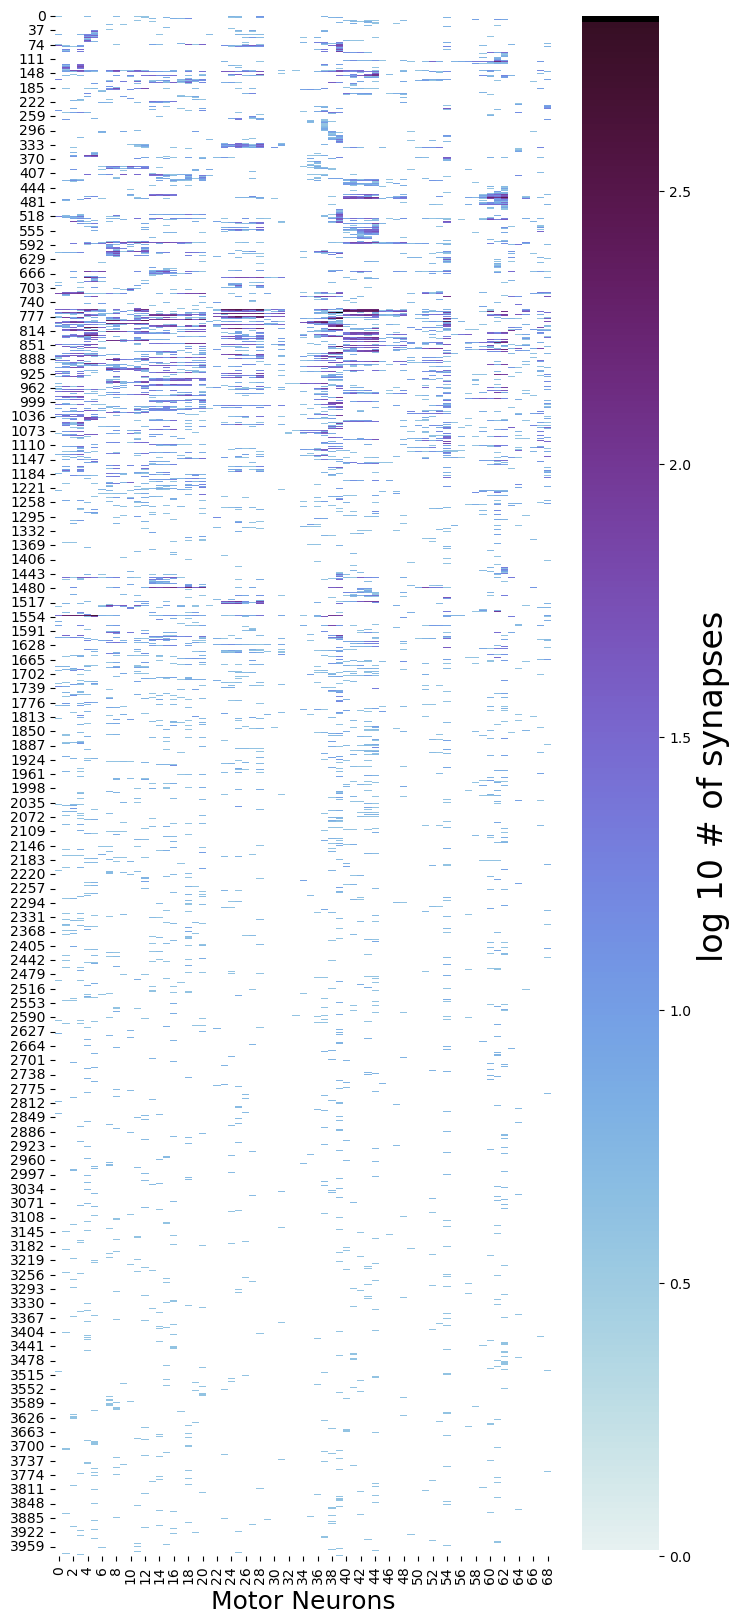

In [40]:
lbls = utils.mn_labels(clustered_pMN_to_MN_df.columns.to_frame(),depth='rank')
# dns = clustered_pMN_to_MN_df.loc['descending']

fig = plt.figure(1, figsize = [8,20])
import cmocean
cmap_alt = cmocean.cm.dense
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(clustered_pMN_to_MN_df.to_numpy()+1), cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()


# Load Motor neuron table and determine cell classes 
My current hierarchy would be: Region (brain,vnc,descending,ascending), segment (T1,2,3,Ab), class (motor, sensory, intersegmental, local), neurotransmitter, primary neurite bundle/hemilineage, type

In [41]:
all_pre_to_mn_df = clustered_pMN_to_MN_df # connectome_create.load_pre_to_mn_df(ext='clustered_ordered')

all_pre_to_mn_df['cell_class']  = ''
print(all_pre_to_mn_df.shape)

All = slice(None)
                    # segID	motor	has_sma	sensory	neck	local   T1_count
all_pre_to_mn_df.loc[(All,  True,   True,   False,  False,  False,  All),'cell_class'] = 'motor'
all_pre_to_mn_df.loc[(All,  True,   True,   True,  False,  False,  All),'cell_class'] = 'motor'
all_pre_to_mn_df.loc[(All,  False,  False,    True,   False,  False,  All),'cell_class'] = 'sensory' 
all_pre_to_mn_df.loc[(All,  False,  True,    True,   False,  False,  All),'cell_class'] = 'sensemns' # always has those weird neurons in there
all_pre_to_mn_df.loc[(All,  False,  False,  False,  True,   False,  All),'cell_class'] = 'descending'
all_pre_to_mn_df.loc[(All,  False,  True,   False,  True,   False,  All),'cell_class'] = 'ascending'
all_pre_to_mn_df.loc[(All,  False,  False,  False,  False,  False,  All),'cell_class'] = 'fragment'
all_pre_to_mn_df.loc[(All,  False,  True,   False,  False,  True,   All),'cell_class'] = 'local'
all_pre_to_mn_df.loc[(All,  False,  True,   False,  False,  False,  All),'cell_class'] = 'intersegmental'
print(all_pre_to_mn_df.cell_class.value_counts())

all_pre_to_mn_df = all_pre_to_mn_df.set_index(keys=['cell_class'],append=True,drop=True,verify_integrity=True)
all_pre_to_mn_df = all_pre_to_mn_df.reset_index(level=['motor','has_soma','sensory','neck','local','non_T1_count'],drop=True)
all_pre_to_mn_df = all_pre_to_mn_df.reorder_levels(['cell_class','segID'],'index')
print(all_pre_to_mn_df.shape)

pre_to_mn_df = all_pre_to_mn_df.loc[(['descending','sensory','intersegmental','local','ascending']),:]
print(pre_to_mn_df.shape)

pre_to_mn_df.head()


# Note 8/2/22 - the the sensory group is currently 117. This includes 111 actual sensory neurons, likely after some proofreading. 
# Then there are 6 sensory neurons with somas. This should change on 8/3, there are still the bilateral mns, but some of the sensory snarls have been proofread


(3984, 70)
cell_class
fragment          2383
local              666
intersegmental     298
descending         232
sensory            192
ascending          175
motor               37
sensemns             1
Name: count, dtype: int64
(3984, 69)
(1563, 69)


side                                                                            L  \
nerve                                                                      Dorsal   
segment                                                                    thorax   
function                                                                    swing   
muscle                        tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                            0   
segID                                                          648518346487756866   
cell_class segID                                                                    
descending 648518346493969399                                                  0    
           648518346496558594                                                  0    
           648518346498261041                                                  0    
           648518346466652526                                                  0    
           648518346479324635                                                  0    

side                                                                 \
nerve                                                                 
segment                                                               
function                                                              
muscle                                                                
rank                                                                  
segID                         648518346491659326 648518346517437482   
cell_class segID                                                      
descending 648518346493969399                  0                  0   
           648518346496558594                  0                  0   
           648518346498261041                  0                  0   
           648518346466652526                  0                  0   
           648518346479324635                  0                  0   

side                                              \
nerve                                              
segment                                            
function                                           
muscle                                             
rank                                               
segID                         648518346479446972   
cell_class segID                                   
descending 648518346493969399                  0   
           648518346496558594                  0   
           648518346498261041                  0   
           648518346466652526                  0   
           648518346479324635                  0   

side                                                              \
nerve                                                    Ventral   
segment                                                   thorax   
function                                                   swing   
muscle                        sternal_anterior_rotator_miller_31   
rank                                                           0   
segID                                         648518346479325585   
cell_class segID                                                   
descending 648518346493969399                                  0   
           648518346496558594                                  7   
           648518346498261041                                  0   
           648518346466652526                                  0   
           648518346479324635                                  0   

side                                              \
nerve                                              
segment                                            
function                                           
muscle                                             
rank                                               
segID                         648518346487504531   
cell_class segID                            

In [42]:
connectome_create.save_pre_to_mn_df(all_pre_to_mn_df,ext='pre_match_to_pool_w_fragments')

c:\Users\tony\Code\connectomics\connectomics\dfs_pre_to_mn\pre_to_mn_df_pre_match_to_pool_w_fragments_20240627.pkl
(3984, 69)


# Assigning preMNs to motor modules
This script answers the following question: Is there a stable match where we can assign a local premotor neuron to a muscle group?
The idea comes from the med school matching algorithm and aims to produce an order to the premotor neurons where the "most important" neurons for a given muscle is assigned to that muscle. This will allow us to look at the connectivity of the local premotors and say, e.g., "this important neuron for tibia flexors is also connected to femur flexors". So, what does "important" mean? To assign premotors to motor modules, for each premotor neuron, we rank the motor modules by the number of combined inputs to the motor modules. For each motor modules, we rank premotor neurons by their contribution to the cluster unit vector. Then we let the matching algorithm work on those rankings. This ranking system is premotor/student optimal, and the lists for the motor modules/school are not limited, so it should aggregate premotor neurons just to their prefered module.

In [43]:
pre_to_mn_df = all_pre_to_mn_df.loc[(['descending','sensory','intersegmental','local','ascending']),:]

In [62]:
mnmi_df = pre_to_mn_df.columns.to_frame()
mpool_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools_coxa_ab()

mnmi_df['module'] = ''
for pk in pool_keys:
    mnmi_df.loc[mpool_dict[pk],'module'] = pk

pre_to_mn_df.columns = pd.MultiIndex.from_frame(mnmi_df)

In [63]:
pref_total_df = pre_to_mn_df.groupby(level='module',axis=1).sum()
pref_total_df = pref_total_df[pool_keys]

max_value_columns = pref_total_df.idxmax(axis=1)

idx = pre_to_mn_df.index.to_frame()
idx['preferred_pool'] = max_value_columns

cell_class_cat = pd.api.types.CategoricalDtype(categories=['descending','sensory','ascending','intersegmental','local'], ordered=True)
pool_cat = pd.api.types.CategoricalDtype(categories=pool_keys, ordered=True)

idx['cell_class'] = idx['cell_class'].astype(cell_class_cat)
idx['preferred_pool'] = idx['preferred_pool'].astype(pool_cat)

idx['outputsynapse_inverse'] = pref_total_df.sum(axis=1).astype(float)**-1

idx = idx[['cell_class','preferred_pool','outputsynapse_inverse','segID']]

new_new_pre_to_mn_df = pre_to_mn_df.copy()
new_new_pre_to_mn_df.index = pd.MultiIndex.from_frame(idx)

new_new_pre_to_mn_df.sort_index(level=['cell_class','preferred_pool','outputsynapse_inverse'],inplace=True,kind='stable')
new_new_pre_to_mn_df = new_new_pre_to_mn_df.droplevel(level='outputsynapse_inverse',axis=0)

In [64]:
connectome_create.save_pre_to_mn_df(new_new_pre_to_mn_df,ext='matched_to_pool')
pre_to_mn_df = new_new_pre_to_mn_df

c:\Users\tony\Code\connectomics\connectomics\dfs_pre_to_mn\pre_to_mn_df_matched_to_pool_20240627.pkl
(1563, 69)


# Add local neuron classification and hemilineage to matrix

In [65]:
pmn_annotation_table = client.materialize.query_table('left_t1_local_premotor_table_v6',timestamp=connectome_create.get_timestamp())

# pmn_annotation_table.classification_system.value_counts()
# pmn_annotation_table.cell_type.value_counts()

In [66]:
# how many of the pmn seg is are not in the matrix
pmn_index = pre_to_mn_df.index.to_frame()
pmn_index = pmn_index.set_index(keys=['segID'],drop=False)
local_pmns  = pmn_index.loc[pmn_index.cell_class=='local']


local_pmns_to_type = local_pmns.loc[~local_pmns.segID.isin(pmn_annotation_table.pt_root_id)]
utils.save_df_csv(local_pmns_to_type,name='left_t1_local_premns_to_type')
local_pmns_to_type.segID.to_list()

./dfs_saved/left_t1_local_premns_to_type_20240627.csv
(1, 3)


[648518346498360113]

In [67]:
inter_pmns  = pmn_index.loc[pmn_index.cell_class=='intersegmental']
utils.save_df_csv(inter_pmns,name='left_t1_inter_premns_to_type')

./dfs_saved/left_t1_inter_premns_to_type_20240627.csv
(298, 3)


In [68]:
# just add classifications and hemilineage to the index, then put the index back on and reorder
pmn_index = pre_to_mn_df.index.to_frame()
pmn_index = pmn_index.set_index(keys=['segID'],drop=False)

pmn_index['classification_system'] = None
pmn_index['cell_type'] = None

for clsys in pmn_annotation_table.classification_system.unique():
    pmn_index.loc[pmn_index.segID.isin(pmn_annotation_table.loc[pmn_annotation_table.classification_system==clsys,'pt_root_id']),'classification_system'] = clsys
    
for ctype in pmn_annotation_table.cell_type.unique():
    pmn_index.loc[pmn_index.segID.isin(pmn_annotation_table.loc[pmn_annotation_table.cell_type==ctype,'pt_root_id']),'cell_type'] = ctype

pre_to_mn_df.index = pd.MultiIndex.from_frame(pmn_index)
pre_to_mn_df = pre_to_mn_df.reorder_levels(['cell_class','preferred_pool','classification_system','cell_type','segID'],'index')


# Add neurotransmitters

## Create lookuptable

In [69]:
classification_system = pre_to_mn_df.index.get_level_values('classification_system').unique().to_numpy()

nt_table = pd.read_csv('./annotations_hl/LacinHLTable.csv')
hl_lut = {'classification_system':classification_system,'hemilineage':classification_system}
hl_lut = pd.DataFrame(data=hl_lut)


In [70]:

for idx,r in hl_lut.iterrows():
    try:
        if np.isnan(r.hemilineage):
            continue
    except TypeError:
        pass
    hl = r.hemilineage
    
    hl_lut.loc[idx,'hemilineage'] = hl

# merge with neurotransmitter table to get a lookuptable
hl_lut = hl_lut.merge(nt_table,how='outer',left_on='hemilineage',right_on='HL')
hl_lut = hl_lut.loc[~hl_lut.hemilineage.isna(),:]

hl_lut_reduced = hl_lut[['classification_system','NT']]

In [71]:
# just operate on the index, where the nt will be
pmn_index_df = pre_to_mn_df.index.to_frame().reset_index(drop=True)

# join the index on cell_type, with NT
pmn_index_df = pmn_index_df.join(hl_lut_reduced.set_index('classification_system'),how='left',on='classification_system')


In [72]:
pmn_index_df

,cell_class,preferred_pool,classification_system,cell_type,segID,NT
0,descending,coxa_promote,NaN,NaN,648518346493883193,NaN
1,descending,coxa_promote,NaN,NaN,648518346497743463,NaN
2,descending,coxa_promote,NaN,NaN,648518346494476087,NaN
3,descending,coxa_promote,NaN,NaN,648518346507377529,NaN
4,descending,coxa_promote,NaN,NaN,648518346494232199,NaN
...,...,...,...,...,...,...
1558,local,ltm_B,19A,19A_mid,648518346504149710,GABA
1559,local,ltm_B,09A,09A,648518346490340104,GABA
1560,local,ltm_B,22A,22A_posterior,648518346521544953,Ach
1561,local,tarsus_depress_medial,12B,12B,648518346484940957,GABA


In [73]:
# reorder the matrix
pmn_index_df = pmn_index_df[['cell_class','preferred_pool','NT','classification_system','cell_type','segID']]
pmn_index_df.NT.value_counts()

NT
Ach     298
GABA    199
Glu     180
Name: count, dtype: int64

# Classify sensory neurons

In [74]:
all_sensory = connectome_create.get_unduplicated_sensory_axon_table(client)

all_sensory = all_sensory[['pt_root_id','classification_system','cell_type']]
all_sensory = all_sensory.rename({'pt_root_id':'segID'},axis=1)

# join the index on cell_type, with NT
pmn_index_df = pmn_index_df.merge(all_sensory,how='left',on='segID',suffixes=['_x','_y'])

sens_rows = (pmn_index_df.cell_class == 'sensory') & (pmn_index_df.classification_system_x.isna())
pmn_index_df.loc[sens_rows,'classification_system_x'] = pmn_index_df.loc[sens_rows].classification_system_y
pmn_index_df.loc[sens_rows,'cell_type_x'] = pmn_index_df.loc[sens_rows].cell_type_y

pmn_index_df.loc[pmn_index_df.cell_class == 'sensory','NT'] = 'Ach'
pmn_index_df = pmn_index_df.drop(['classification_system_y','cell_type_y'],axis=1)
pmn_index_df = pmn_index_df.rename(columns={'classification_system_x':'classification_system','cell_type_x':'cell_type'})

pre_to_mn_df.index = pd.MultiIndex.from_frame(pmn_index_df)

glia = pre_to_mn_df[pre_to_mn_df.index.get_level_values('cell_type') == 'Gial_error']
no_glia = pre_to_mn_df[pre_to_mn_df.index.get_level_values('cell_type') != 'Gial_error']

In [93]:
import connectome_create
connectome_create.save_pre_to_mn_df(no_glia,ext='matched_typed_with_nt')

.\dfs_pre_to_mn\pre_to_mn_df_matched_typed_with_nt_20240627.pkl
(1546, 69)


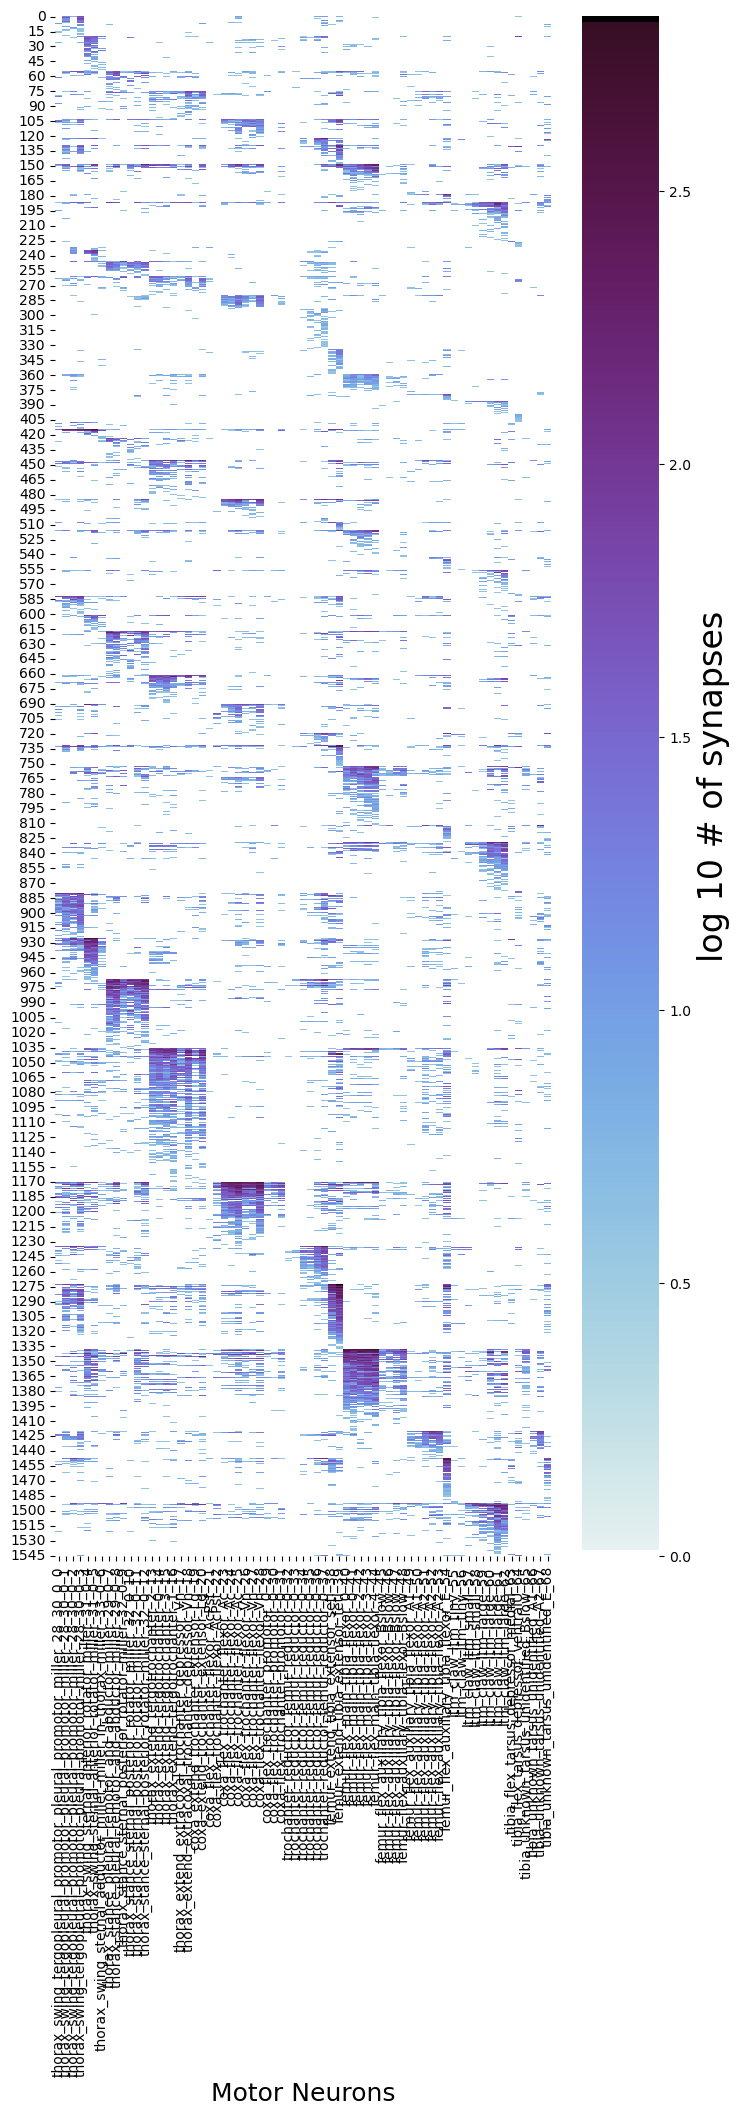

True


In [76]:
lbls = utils.mn_labels(pre_to_mn_df.columns.to_frame(),depth='rank')
dns = pre_to_mn_df.loc['descending']

fig = plt.figure(1, figsize = [8,20])
import cmocean
cmap_alt = cmocean.cm.dense
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(no_glia.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()

fig2 = ax.get_figure()
print(fig==fig2)
# fig.savefig('./figpanels/matched_premotor_to_motor.eps',format='eps',dpi=300, bbox_inches='tight')
fig.savefig('./figpanels/matched_premotor_to_motor.svg',format='svg',transparent=True,dpi=600)

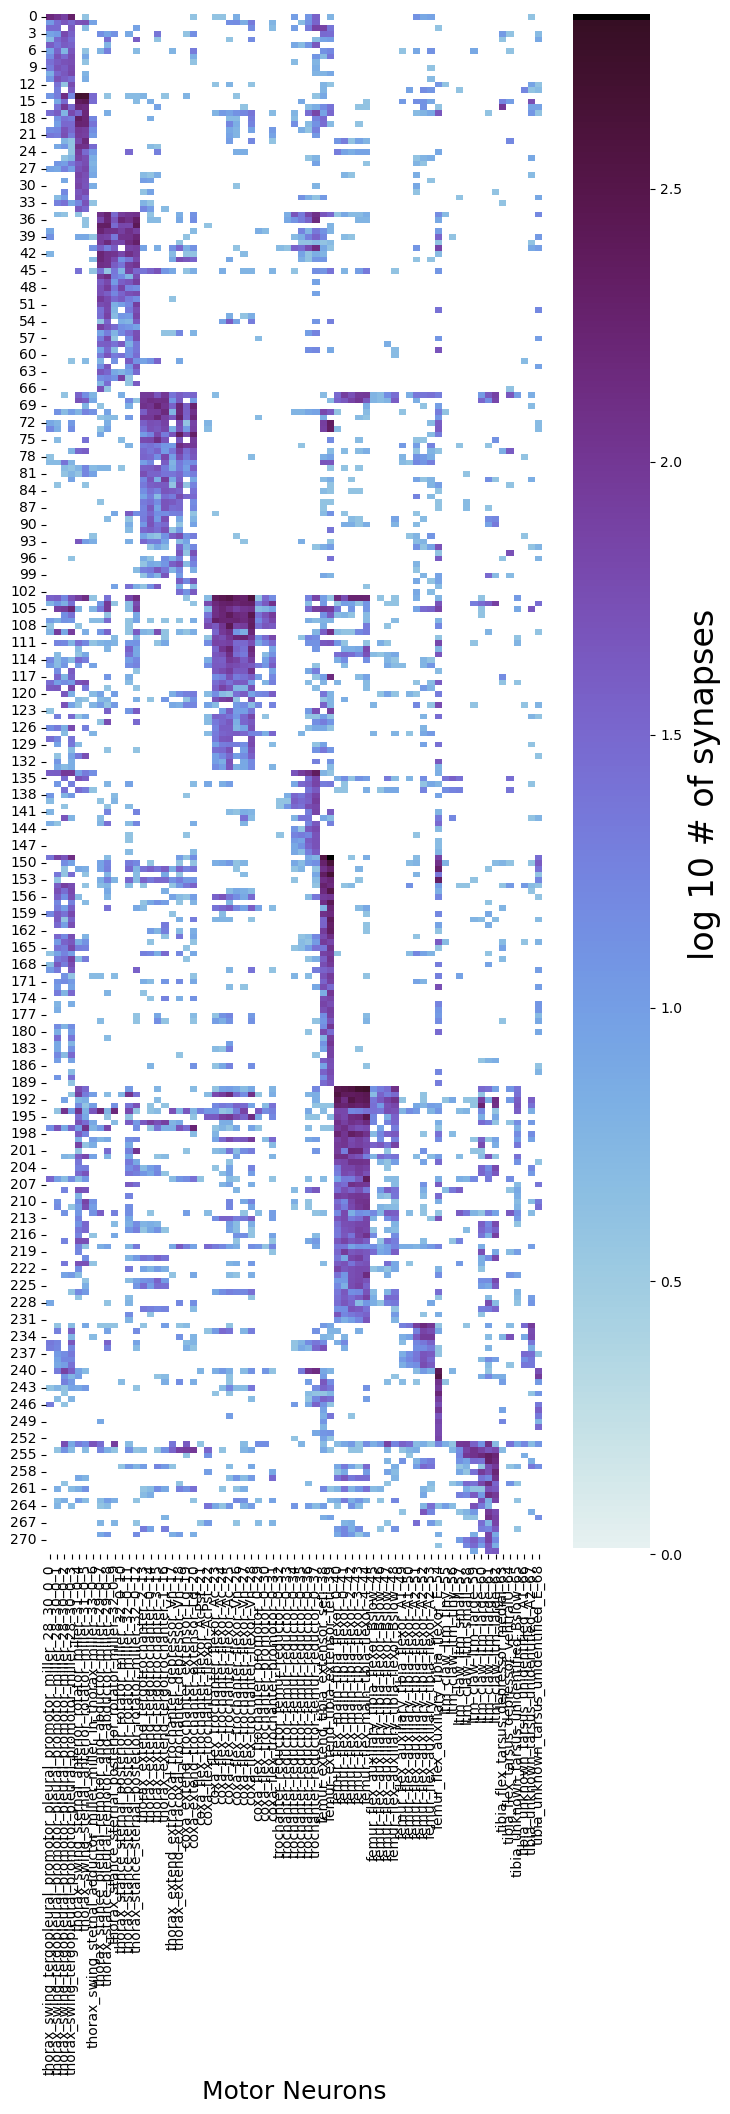

In [77]:
lbls = utils.mn_labels(pre_to_mn_df.columns.to_frame(),depth='rank')
dns = pre_to_mn_df.loc['descending']
lcl = no_glia.loc['local']
lcl = lcl.loc[(lcl>40).any(axis=1),:]

fig = plt.figure(1, figsize = [8,20])
import cmocean
cmap_alt = cmocean.cm.dense
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(lcl.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()


# fig.savefig('./figpanels/matched_premotor_to_motor.eps',format='eps',dpi=300, bbox_inches='tight')

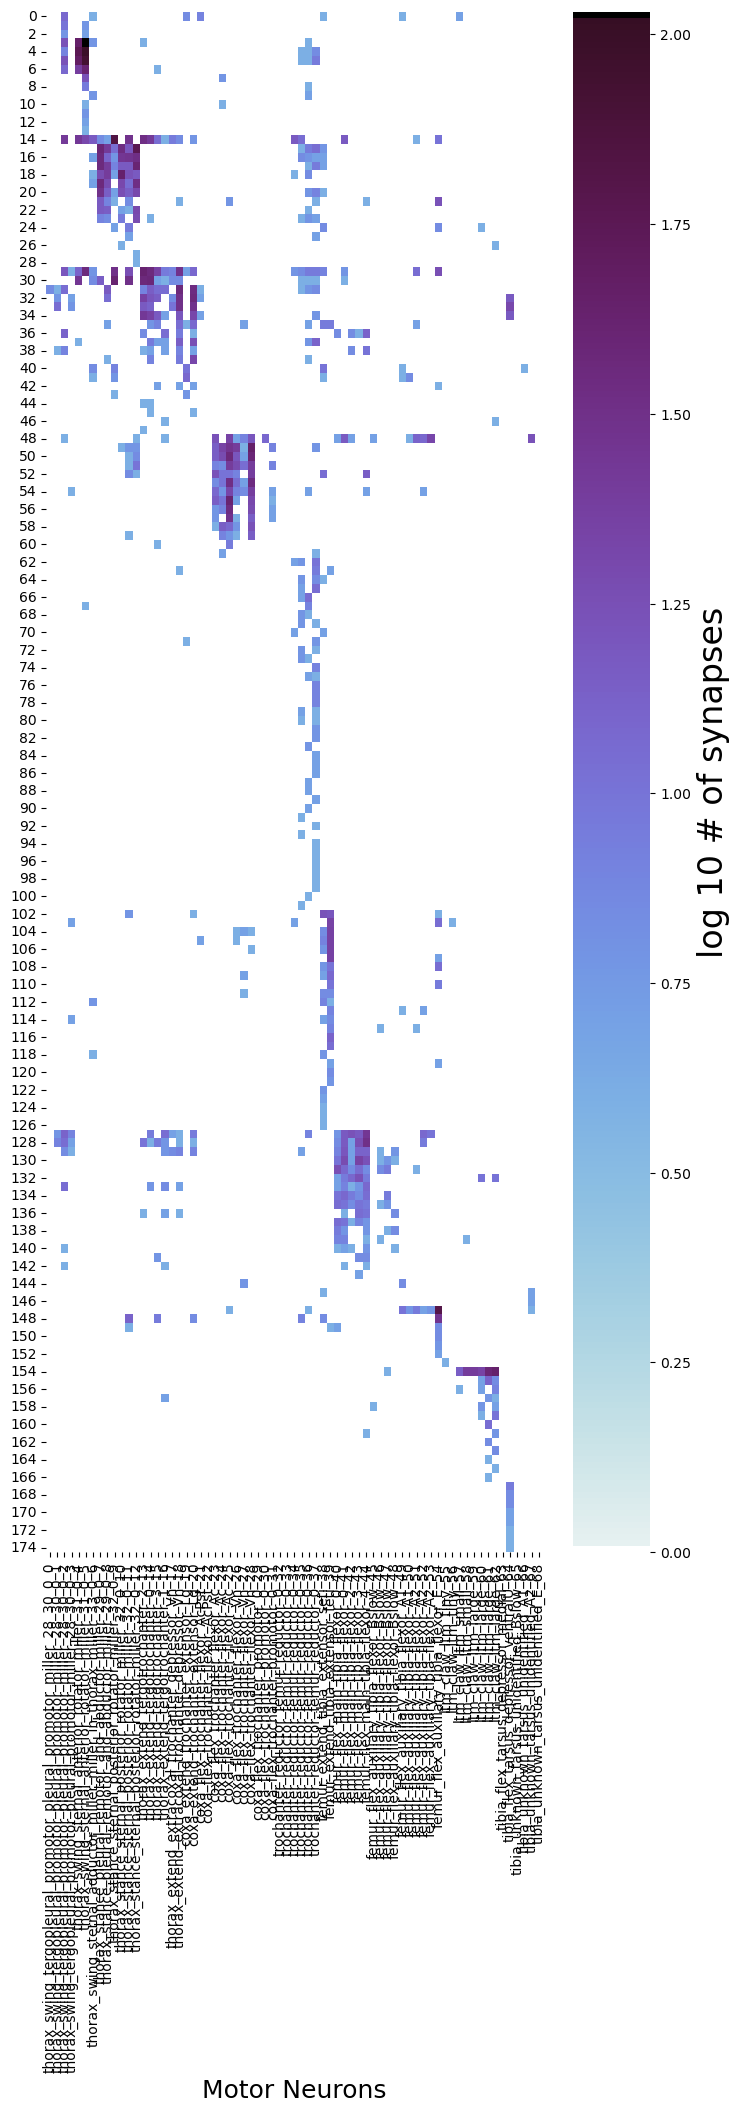

In [78]:
lbls = utils.mn_labels(pre_to_mn_df.columns.to_frame(),depth='rank')
dns = pre_to_mn_df.loc['descending']
lcl = no_glia.loc['local']
# lcl = lcl.loc[(lcl>40).any(axis=1),:]
lcl = no_glia.loc['sensory']

fig = plt.figure(1, figsize = [8,20])
import cmocean
cmap_alt = cmocean.cm.dense
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(lcl.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()

In [79]:
lcl.min(axis=1)

preferred_pool           NT   classification_system  cell_type        segID             
coxa_promote             Ach  T1_L_Sensory           CO_hook_flx      648518346481857725    0
                                                     Hairplate        648518346514478279    0
                                                                      648518346491165987    0
coxa_rotate_adduct       Ach  ProAN_Afferent         Hairplate_CoHP4  648518346498320945    0
                                                                      648518346489643225    0
                                                                                           ..
tarsus_depress_ventralU  Ach  T1_L_Sensory           Bristle_neuron   648518346471994011    0
                                                                      648518346491817233    0
                              T1_L_Unsure            Unsure           648518346491175544    0
                              T1_L_Sensory           Bristle_neur

In [80]:
lcl = lcl.loc[(lcl>40).any(axis=1),:]

In [81]:
no_glia.sum(axis=0).to_list()

[1484,
 4055,
 4056,
 6450,
 6476,
 7292,
 1059,
 4645,
 5626,
 2089,
 2358,
 3956,
 5723,
 3693,
 3933,
 4247,
 4131,
 1617,
 5415,
 1729,
 4705,
 81,
 737,
 2644,
 3765,
 6236,
 2910,
 2935,
 6229,
 396,
 420,
 1225,
 19,
 51,
 739,
 768,
 2291,
 5188,
 6249,
 12702,
 4729,
 5498,
 6085,
 7614,
 8731,
 443,
 497,
 1180,
 1960,
 363,
 375,
 1420,
 1570,
 1751,
 6621,
 166,
 231,
 569,
 724,
 1315,
 3186,
 4869,
 5918,
 664,
 1244,
 620,
 285,
 1659,
 1579]

In [82]:
print(no_glia.index.get_level_values('cell_class').value_counts())

cell_class
local             666
intersegmental    298
descending        232
sensory           175
ascending         175
Name: count, dtype: int64


In [83]:
print(no_glia.index.get_level_values('preferred_pool').value_counts())

preferred_pool
trochanter_extend          250
tibia_ta_flex_A            213
ltm_B                      175
coxa_posterior             170
trochanter_flex            146
tibia_extend               138
coxa_rotate_adduct         113
femur_reduct               101
coxa_promote                95
tibia_ta_flex_C             81
tibia_ta_flex_B             39
tarsus_depress_ventralU     18
ltm_A                        4
tarsus_depress_medial        3
Name: count, dtype: int64


In [84]:
print(no_glia.index.get_level_values('NT').value_counts())

NT
Ach     473
GABA    199
Glu     180
Name: count, dtype: int64


In [85]:
print(no_glia.index.get_level_values('classification_system').value_counts())

classification_system
T1_L_Sensory      128
03A                88
22A                85
16B                69
13A                67
21A                43
13B                42
04B                41
08A                34
14A                34
19A                29
20A                27
12B                26
09A                25
01A                22
23B                17
17A                13
T1_L_Afferent      13
DProN_Unsure       11
01B                 8
ProAN_Afferent      4
T1_L_Unsure         4
VProN_Unsure        3
T1L_VProN           3
VProN_Afferent      3
DProN_Afferent      3
07B                 3
19B                 2
T2_R_Unsure         2
06A                 2
T2_L_Unsure         1
Name: count, dtype: int64


In [86]:
print(no_glia.index.get_level_values('cell_type').value_counts())

cell_type
03A                               88
16B                               69
13A                               67
Bristle_neuron                    57
22A_posterior                     56
                                  ..
17A_central_core_post_mirrored     1
17A_dorsal_lateral                 1
06A                                1
19B_primary                        1
06A_primary                        1
Name: count, Length: 62, dtype: int64


In [87]:
# mpool_dict = utils.get_motor_pool_tuple_dict()
# pool_keys = [
#     'thorax_swing',
#     'thorax_stance',
#     'trochanter_extension',
#     'trochanter_flexion',
#     'femur_reductor',
#     'tibia_extensor',
#     'main_tibia_flexor',
#     # 'auxiliary_tibia_flexor_A',
#     'auxiliary_tibia_flexor_B',
#     'auxiliary_tibia_flexor_E',
#     'ltm',
#     'tarsus_depressor_med_venU',
#     'tarsus_depressor_noid',
#     ]

# a13a = no_glia.loc[(All,All,All,All,'13A')]
b13b = no_glia.loc[(All,All,All,All,'13B')]

In [88]:
b13b.index.get_level_values('segID').to_list()

[648518346479452114,
 648518346481773727,
 648518346483247780,
 648518346488638136,
 648518346490527754,
 648518346490510428,
 648518346502572199,
 648518346486788557,
 648518346493379100,
 648518346466026288,
 648518346515287367,
 648518346502544454,
 648518346507540857,
 648518346486876131,
 648518346495884688,
 648518346486230114,
 648518346494700053,
 648518346499391207,
 648518346489538905,
 648518346479413948,
 648518346480891872,
 648518346495014834,
 648518346502422611,
 648518346500629941,
 648518346503216507,
 648518346494034720,
 648518346496014026,
 648518346502560423,
 648518346487557034,
 648518346509286522,
 648518346486909081,
 648518346490190107,
 648518346479918486,
 648518346491551162,
 648518346491559354,
 648518346493240384,
 648518346496015179,
 648518346492911534,
 648518346480436283,
 648518346480108966,
 648518346504949894,
 648518346477911789]

In [89]:
client.materialize.get_tables()

['wing_motor_neuron_table_v0',
 'soma_jan2022',
 'synapses_nov2022',
 'proofread_second_pass',
 'cell_ids_v2',
 'motor_neuron_table_v7',
 'proofreading_status_jasper',
 'somas_dec2022',
 'upstream_feco_axons',
 'nucleus_mar2022',
 'left_t3_mn_order_reftable_v0',
 'downstream_feco_axons_v1',
 'synapse_regions_v1',
 'neuron_somas_dec2022',
 'topo_23b_table_v0',
 'downstream_10b_table_v0',
 'downstream_hair_plate_axon_table_v0',
 'proofread_by_andrewcook',
 'peripheral_nerves',
 'grooming_command_like_neurons_v1',
 'feco_axons_v0',
 'glia_somas_dec2022',
 'gustatory_downstream_t1l',
 'legcs_axons',
 'upstream_hair_plate_axon_table_v0',
 'sensory_admn_left',
 'left_t1_local_premotor_table_v5',
 'neck_connective',
 'right_t2_mn_cell_type_table_v0',
 'right_t3_mn_cell_type_table_v0',
 'abdominal_sensory_axon_table_v0',
 'neurotransmitter_hemilineage_table',
 'downstream_feco_axons_v0',
 'right_t2_mn_order_reftable_v0',
 'hair_plate_table',
 'downstream_bristle_table_v0',
 'bristle_axon_table

In [90]:
all_pre_to_mn_df.sum(axis=0).to_list()

[1646,
 4459,
 4504,
 6955,
 7090,
 7865,
 1141,
 5070,
 6107,
 2219,
 2525,
 4246,
 6169,
 4113,
 4468,
 4775,
 4816,
 1726,
 6068,
 1924,
 5193,
 96,
 850,
 2829,
 4020,
 6758,
 3040,
 3155,
 6545,
 426,
 449,
 1322,
 19,
 58,
 802,
 809,
 2444,
 5485,
 6879,
 14323,
 5074,
 6023,
 6500,
 8279,
 9616,
 474,
 515,
 1229,
 2119,
 384,
 399,
 1553,
 1770,
 1897,
 7524,
 173,
 253,
 604,
 790,
 1428,
 3555,
 5546,
 6854,
 700,
 1384,
 658,
 298,
 1829,
 1718]

# Show some connectivity 

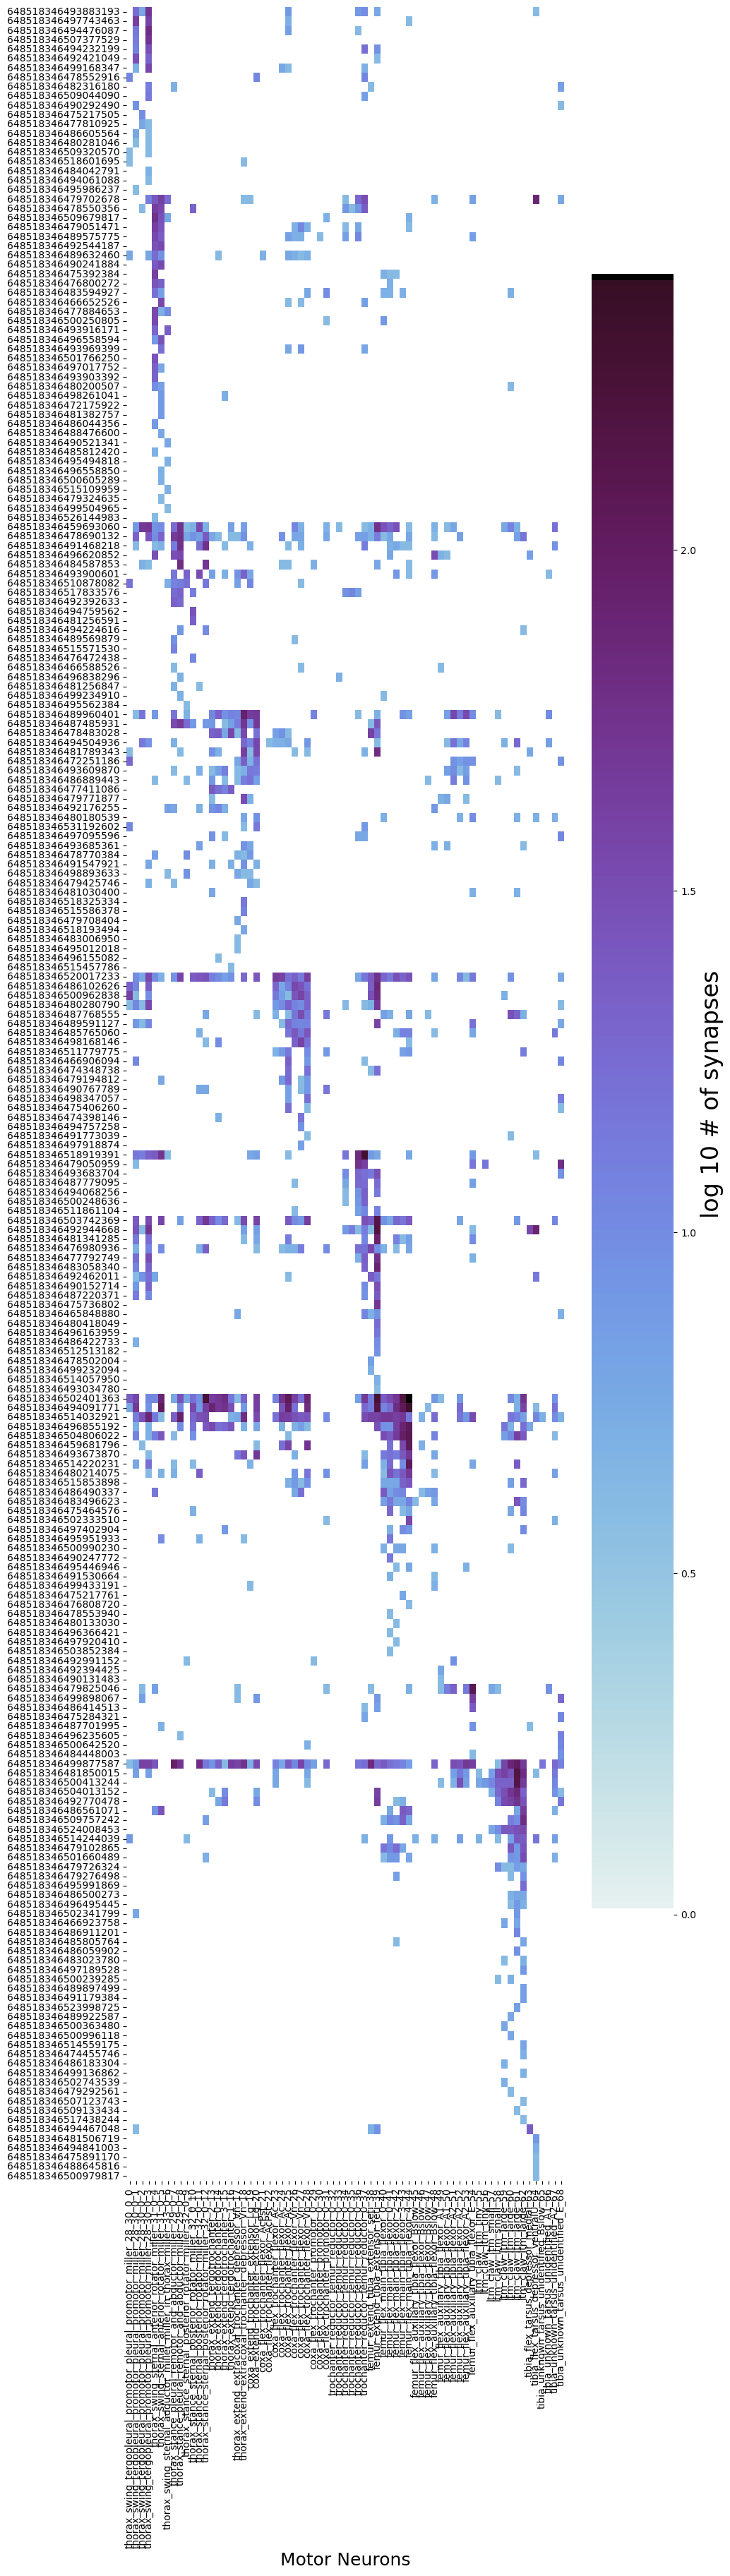

In [91]:
lbls = utils.mn_labels(pre_to_mn_df.columns.to_frame(),depth='rank')
dns = pre_to_mn_df.loc['descending']
snsry = no_glia.loc['sensory']
# lcl = lcl.loc[(lcl>40).any(axis=1),:]

fig = plt.figure(1, figsize = [10,40])
import cmocean
cmap_alt = cmocean.cm.dense
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(dns.to_numpy()+1), xticklabels=lbls,yticklabels=dns.index.get_level_values('segID').to_list(), cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()

snsry.to_csv('./dfs_saved/sensory_preMNs_20231018.csv')

In [ ]:
lcl.iloc[100:152,38:56]
lcl.to_csv('./dfs_saved/sensory_preMNs.csv')

# Load the recent df

In [ ]:
import connectome_create
pre_to_mn_df = connectome_create.load_pre_to_mn_df(ext='matched_typed_with_nt')
pre_to_mn_df.shape

In [ ]:
pre_to_mn_df.to_csv('./dfs_saved/pre_mn_df_matched_typed_with_nt.csv')

In [ ]:
pre_to_mn_df.loc[pre_to_mn_df.index.get_level_values('segID')==648518346499877587]

In [ ]:
pre_to_mn_df.loc[pre_to_mn_df.index.get_level_values('segID')==648518346526268631]